# Connect to DB

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import datetime
import copy
import seaborn as sns
import scipy
import psycopg2

In [3]:
# Set params for all queries
start_date = datetime.datetime(2022, 9, 1)
end_date = datetime.datetime(2022, 9, 8)
REVIEWER_TIMEOUT = 300

In [4]:
username = input("Username: ")
password = input("Password: ")

# Clear output
from IPython. display import clear_output
clear_output()

In [5]:
conn = psycopg2.connect(
   user = username,
   password = password,
   host = '172.16.0.213',
   port = '5432',
   database = 'portal-production'
)
cursor = conn.cursor()

# Estimating Reviewer Capacity

In [6]:
# Query the review database
sql = """
SELECT
created_at,
user_id,
EXTRACT(epoch FROM time_diff)
FROM (SELECT 
*,
(created_at - LAG(created_at) OVER (ORDER BY user_id, created_at)) as time_diff
FROM api_incidentfeedback
WHERE created_at >= %s and created_at < %s
ORDER BY user_id, created_at) as x
"""

review_time_diff_df = pd.read_sql(sql, conn, params=[start_date, end_date]);
review_time_diff_df

,created_at,user_id,date_part
0,2022-09-01 11:40:17.969122+00:00,14,NaN
1,2022-09-01 11:40:20.455246+00:00,14,2.486124
2,2022-09-01 11:40:24.302483+00:00,14,3.847237
3,2022-09-01 11:40:27.957033+00:00,14,3.654550
4,2022-09-01 11:40:30.198742+00:00,14,2.241709
...,...,...,...
57393,2022-09-07 16:00:12.301924+00:00,208,47.986531
57394,2022-09-07 16:00:50.738009+00:00,208,38.436085
57395,2022-09-07 16:01:39.806836+00:00,208,49.068827
57396,2022-09-07 16:02:21.022883+00:00,208,41.216047


In [7]:
# Remove outliers and NaNs
review_time_diff_df = review_time_diff_df.dropna()
review_time_diff_df = review_time_diff_df[review_time_diff_df['date_part'] > 0]
review_time_diff_df = review_time_diff_df[review_time_diff_df['date_part'] < REVIEWER_TIMEOUT]
print(review_time_diff_df.columns)
review_time_diff_df.date_part

Index(['created_at', 'user_id', 'date_part'], dtype='object')


1         2.486124
2         3.847237
3         3.654550
4         2.241709
5         4.401962
           ...    
57392    81.849425
57393    47.986531
57394    38.436085
57395    49.068827
57396    41.216047
Name: date_part, Length: 56495, dtype: float64

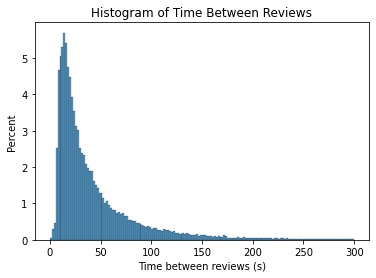

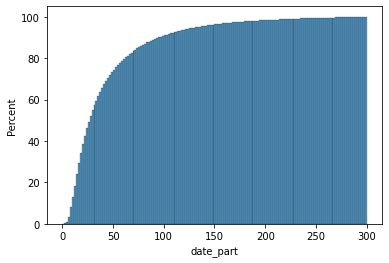

In [8]:
sns.histplot(review_time_diff_df.date_part,stat='percent').set(title='Histogram of Time Between Reviews', xlabel='Time between reviews (s)')
plt.show()

sns.histplot(review_time_diff_df.date_part, cumulative=True, stat='percent')
plt.show()

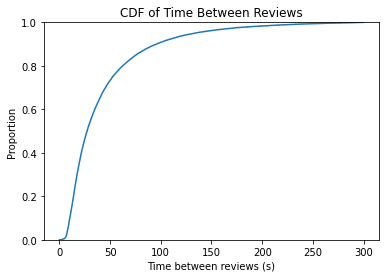

80% of incidents are reviewed in 62.51 seconds       
Approx. 57.59 incidents reviewed per reviewer per hour


In [9]:
sns.ecdfplot(review_time_diff_df.date_part).set(title='CDF of Time Between Reviews', xlabel='Time between reviews (s)')
plt.show()

PERCENTILE_THRESH = 80

percentile = np.percentile(review_time_diff_df.date_part, [PERCENTILE_THRESH])[0]
capacity = 60*60/percentile

                              
print(f"{PERCENTILE_THRESH}% of incidents are reviewed in {percentile:.2f} seconds \
      \nApprox. {capacity:.2f} incidents reviewed per reviewer per hour")


## Conclusions

A good way to measure reviewer capacity is to look at the distribution of the review rates. We can define the hourlycapacity of an individual reviewer as the amount of time it takes to review 80% of incidents (80th percentile). Our statistical analysis shows that this capacity is ~56 incidents reviewed per reviewer per hour.

In the next sections, we will use this peak capacity to analyze the current reviewer utilization and estimate the futrue demand for reviewers.

# Estimating Reviewer Utilization

In [10]:
# Query TODO check reviewers
sql = """
SELECT 
a.hour_group,
num_reviews / active_reviewers as reviews_per_reviewer
FROM (SELECT
TO_CHAR(
        created_at,
        'YY-MM-DD:HH24'
    ) hour_group,
COUNT(id) AS num_reviews
FROM api_incidentfeedback
WHERE created_at >= %s and created_at < %s
GROUP BY hour_group) as a
inner join (SELECT
TO_CHAR(
        created_at,
        'YY-MM-DD:HH24'
    ) hour_group,
  count(distinct user_id) as active_reviewers
FROM api_incidentfeedback
GROUP BY 1
ORDER BY 1) as b
ON a.hour_group = b.hour_group
order by 1
"""
df = pd.read_sql(sql, conn, params=[start_date, end_date]);
df # prints in a better format


,hour_group,reviews_per_reviewer
0,22-09-01:00,57
1,22-09-01:01,83
2,22-09-01:02,89
3,22-09-01:03,58
4,22-09-01:04,67
...,...,...
163,22-09-07:19,70
164,22-09-07:20,67
165,22-09-07:21,55
166,22-09-07:22,66


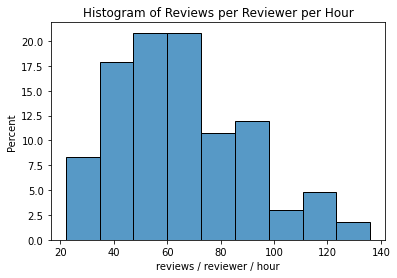

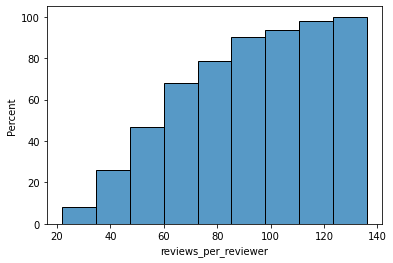

In [11]:
sns.histplot(df.reviews_per_reviewer,stat='percent').set(title='Histogram of Reviews per Reviewer per Hour', xlabel='reviews / reviewer / hour')
plt.show()

sns.histplot(df.reviews_per_reviewer, cumulative=True, stat='percent')
plt.show()

Reviewers are below capacity 41.67% of the time


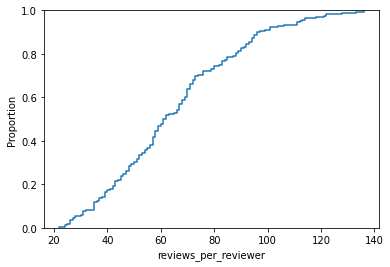

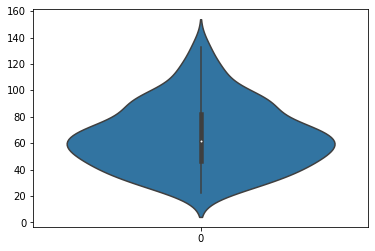

In [12]:
percent_below_capacity = scipy.stats.percentileofscore(df.reviews_per_reviewer, [capacity])
print(f"Reviewers are below capacity {percent_below_capacity:.2f}% of the time")

sns.ecdfplot(df.reviews_per_reviewer)
plt.show()

sns.violinplot(df.reviews_per_reviewer)
plt.show()

# Incident Generation Analysis

In [13]:
from scipy.stats import f_oneway


def plot_partition(df, partition_name):
    unique_partitions = np.unique(df[partition_name])
    for i in unique_partitions:
        partition = df[df[partition_name] == i].num_incidents
        sns.histplot(partition, alpha=0.25, stat='density')

    plt.show()

    # We can use an F-test to analuze the variance to determine if the distribution of n-incidents are the same
    # https://en.wikipedia.org/wiki/F-test
    # https://en.wikipedia.org/wiki/Analysis_of_variance
    income_groups = [df.loc[df[partition_name]==arm, 'num_incidents'].values for arm in df[partition_name].dropna().unique()]
    stat, p_value = f_oneway(*income_groups)
    print(f"F Test: statistic={stat:.4f}, p-value={p_value:.4f}")

In [14]:
# Query the incidents database, group by org
organization_query = """
SELECT 
*
FROM (SELECT
TO_CHAR(
        created_at,
        'YY-MM-DD:HH24'
    ) hour_group,
COUNT(id) AS num_incidents,
organization_id
FROM api_incident
WHERE created_at >= %s and created_at < %s
GROUP BY hour_group, organization_id) as a
order by 1
"""

incidents_organization_df = pd.read_sql(organization_query, conn, params=[start_date, end_date]);
incidents_organization_df

,hour_group,num_incidents,organization_id
0,22-09-01:00,135,3
1,22-09-01:00,46,4
2,22-09-01:00,28,7
3,22-09-01:01,137,3
4,22-09-01:01,38,4
...,...,...,...
665,22-09-07:22,49,8
666,22-09-07:23,138,3
667,22-09-07:23,36,4
668,22-09-07:23,34,7


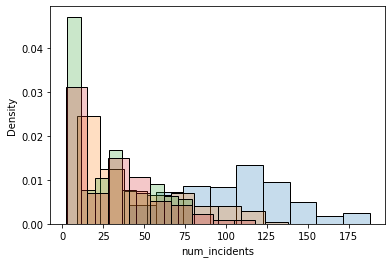

F Test: statistic=282.7481, p-value=0.0000


In [15]:
plot_partition(incidents_organization_df, 'organization_id')

In [16]:
# Query the incidents database, group by org
zone_query = """
SELECT 
*
FROM (SELECT
TO_CHAR(
        created_at,
        'YY-MM-DD:HH24'
    ) hour_group,
COUNT(id) AS num_incidents,
zone_id
FROM api_incident
WHERE created_at >= %s and created_at < %s
GROUP BY hour_group, zone_id) as a
order by 1
"""

incidents_zone_df = pd.read_sql(zone_query, conn, params=[start_date, end_date]);
incidents_zone_df

,hour_group,num_incidents,zone_id
0,22-09-01:00,30,1
1,22-09-01:00,19,2
2,22-09-01:00,17,4
3,22-09-01:00,75,12
4,22-09-01:00,1,14
...,...,...,...
1657,22-09-07:23,32,15
1658,22-09-07:23,25,16
1659,22-09-07:23,26,17
1660,22-09-07:23,8,18


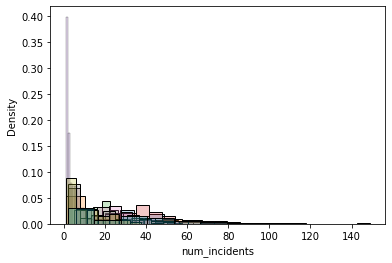

F Test: statistic=81.2279, p-value=0.0000


In [17]:
plot_partition(incidents_zone_df, 'zone_id')

In [18]:
# Query the incidents database, group by camera
camera_query = """
SELECT 
*
FROM (SELECT
TO_CHAR(
        created_at,
        'YY-MM-DD:HH24'
    ) hour_group,
COUNT(id) AS num_incidents,
camera_id
FROM api_incident
WHERE created_at >= %s and created_at < %s
GROUP BY hour_group, camera_id) as a
order by 1
"""

incidents_camera_df = pd.read_sql(camera_query, conn, params=[start_date, end_date]);
incidents_camera_df

,hour_group,num_incidents,camera_id
0,22-09-01:00,1,22
1,22-09-01:00,4,23
2,22-09-01:00,1,24
3,22-09-01:00,5,27
4,22-09-01:00,2,30
...,...,...,...
11175,22-09-07:23,1,145
11176,22-09-07:23,1,146
11177,22-09-07:23,5,147
11178,22-09-07:23,2,148


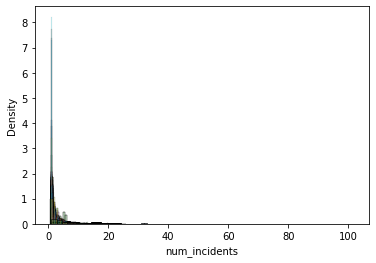

F Test: statistic=67.4938, p-value=0.0000


In [19]:
plot_partition(incidents_camera_df, 'camera_id')

In [20]:
# Query the incidents database, group by camera & incident_type
camera_incident_query = """
SELECT 
*,
camera_id * 1000 + incident_type_id as camera_incident
FROM (SELECT
TO_CHAR(
        created_at,
        'YY-MM-DD:HH24'
    ) hour_group,
COUNT(id) AS num_incidents,
camera_id,
incident_type_id
FROM api_incident
WHERE created_at >= %s and created_at < %s
GROUP BY hour_group, camera_id, incident_type_id) as a
order by 1
"""

incidents_camera_incident_df = pd.read_sql(camera_incident_query, conn, params=[start_date, end_date]);
incidents_camera_incident_df

,hour_group,num_incidents,camera_id,incident_type_id,camera_incident
0,22-09-01:00,1,22,13,22013
1,22-09-01:00,2,23,8,23008
2,22-09-01:00,1,23,11,23011
3,22-09-01:00,1,23,13,23013
4,22-09-01:00,1,24,13,24013
...,...,...,...,...,...
18943,22-09-07:23,1,147,15,147015
18944,22-09-07:23,1,148,8,148008
18945,22-09-07:23,1,148,13,148013
18946,22-09-07:23,2,149,12,149012


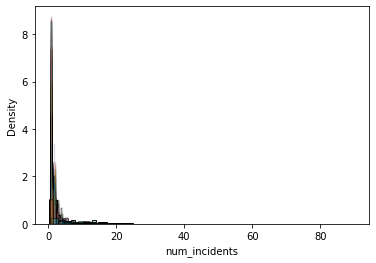

F Test: statistic=37.6129, p-value=0.0000


In [21]:
plot_partition(incidents_camera_incident_df, 'camera_incident')

In [22]:
"""
It's likely that the F-test will perform better when slicing by the specific incident type id. We will save this analysis for the futuere if we find it relevant.
"""

"\nIt's likely that the F-test will perform better when slicing by the specific incident type id. We will save this analysis for the futuere if we find it relevant.\n"

## Analysis

We performed an F-test for Analysis of Variance (ANOVA) for similarity in distributions of the number of incidents generated per hour. We see that we have the least variance between distributions when we group by both the camera and incident_type_id.

Therefore, we can use this grouping to estimate the number of incidents generated for each camera-incident_type for all future site deployments.

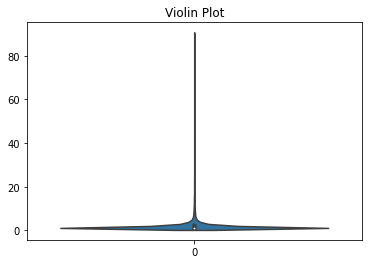

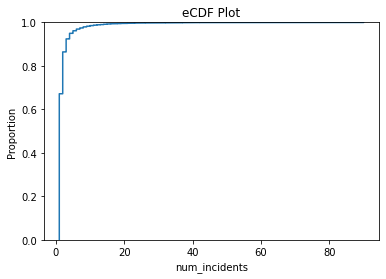

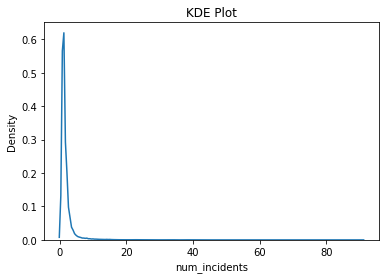

There are 3.00 incidents generated per camera per incident type per hour 90% of the time


In [23]:
df = incidents_camera_incident_df

sns.violinplot(df.num_incidents).set(title='Violin Plot')
plt.show()
sns.ecdfplot(df.num_incidents).set(title='eCDF Plot')
plt.show()
sns.kdeplot(df.num_incidents).set(title='KDE Plot')
plt.show()

PERCENTILE_THRESH = 90

percentile = np.percentile(df.num_incidents, [PERCENTILE_THRESH])[0]
                              
print(f"There are {percentile:.2f} incidents generated per camera per incident type per hour {PERCENTILE_THRESH}% of the time")

# Queue Theory

The review queue can be modeled as an [M/M/c Queue](https://en.wikipedia.org/wiki/M/M/c_queue). This is a type of well-studied queue where the arrivals (incidents) occur in a Poisson distribution, the service time (time to review) have an exponential distribution, and there are "c" servers (reviewers).

Since M/M/c queues are well-studied, we can easily measure many parameters such as response time, stability of the system, number of needed reviewers, probability of idle reviewers, etc. We can do this analysis in the future when we need the results, but we will not do it now for the sake of time.